Import library

In [ ]:
# Step 1: Install necessary libraries (optional, Colab usually has most pre-installed)
!pip install nltk --quiet
!pip install scikit-learn --quiet

# Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Step 3: Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
file_path = "/content/drive/MyDrive/NLP_A3/dataset.csv"
df = pd.read_csv(file_path)

In [ ]:
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (1000, 11)


,User_ID,User_Text,Sentiment_Label,Recommended_Song_ID,Song_Name,Artist,Genre,Tempo (BPM),Mood,Energy,Danceability
0,U1,Way ball purpose public experience recently re...,Sad,S1,Someone Like You,Adele,Pop,67,Melancholic,Low,Low
1,U2,Save officer two myself a.,Happy,S2,Happy,Pharrell Williams,Pop,160,Joyful,High,High
2,U3,Decade ahead everyone environment themselves a...,Relaxed,S3,Clair de Lune,Debussy,Classical,60,Soothing,Low,Low
3,U4,Best change letter citizen try ask quality pro...,Happy,S4,Happy,Pharrell Williams,Pop,160,Joyful,High,High
4,U5,Worker player chance kind actually.,Happy,S5,Happy,Pharrell Williams,Pop,160,Joyful,High,High


In [ ]:
# Display shape and sample
print("Shape:", df.shape)
df[['User_Text', 'Sentiment_Label']].head()

Shape: (1000, 11)


,User_Text,Sentiment_Label
0,Way ball purpose public experience recently re...,Sad
1,Save officer two myself a.,Happy
2,Decade ahead everyone environment themselves a...,Relaxed
3,Best change letter citizen try ask quality pro...,Happy
4,Worker player chance kind actually.,Happy


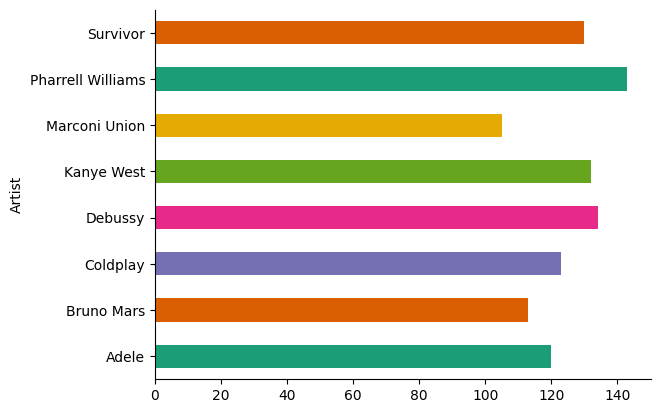

In [ ]:
# @title Artist

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Artist').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

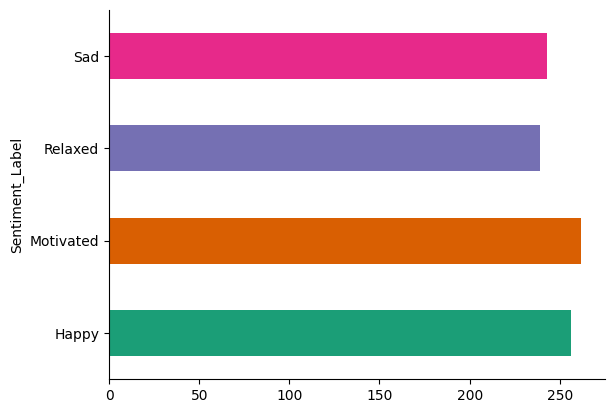

In [ ]:
# @title Sentiment_Label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Sentiment_Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Text Cleaning Function
This function will:

Convert to lowercase

Remove punctuation and numbers

Remove stopwords

Lemmatize tokens

In [ ]:
# === 4. Preprocessing === #
inflect_engine = inflect.engine()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) - {'no', 'not'}

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', lambda x: inflect_engine.number_to_words(x.group()), text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return ' '.join(cleaned_tokens)


In [ ]:
# Apply preprocessing
df['clean_text'] = df['User_Text'].astype(str).apply(preprocess_text)

In [ ]:
# === 5. Tokenization & Padding === #
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
word_index = tokenizer.word_index

max_length = 100
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
# === 6. Encode Labels === #
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentiment_Label'])
y_cat = to_categorical(y)


In [ ]:
# === 7. Train-Test Split === #
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)


In [ ]:
# === 8. Build Model (2-layer LSTM) === #
vocab_size = len(word_index) + 1
embedding_dim = 100
num_classes = y_cat.shape[1]

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(256, return_sequences=True),
    Dropout(0.5),
    LSTM(256),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# === 9. Train Model === #
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2865 - loss: 1.3878 - val_accuracy: 0.2850 - val_loss: 1.3847
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2666 - loss: 1.3862 - val_accuracy: 0.2550 - val_loss: 1.3884
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2563 - loss: 1.3872 - val_accuracy: 0.2850 - val_loss: 1.3842
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2722 - loss: 1.3923 - val_accuracy: 0.2400 - val_loss: 1.3884
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2795 - loss: 1.3843 - val_accuracy: 0.2400 - val_loss: 1.3905
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2801 - loss: 1.3870 - val_accuracy: 0.2400 - val_loss: 1.3850
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2250 - loss: 1.3880 - val_accuracy: 0.2400 - val_loss: 1.3874
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2635 - loss: 1.3866 - val_accuracy: 0.2850 - v

In [ ]:
# === 10. Evaluation === #
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Classification Report:

              precision    recall  f1-score   support

       Happy       0.00      0.00      0.00        48
   Motivated       0.28      1.00      0.44        57
     Relaxed       0.00      0.00      0.00        44
         Sad       0.00      0.00      0.00        51

    accuracy                           0.28       200
   macro avg       0.07      0.25      0.11       200
weighted avg       0.08      0.28      0.13       200


Confusion Matrix:

[[ 0 48  0  0]
 [ 0 57  0  0]
 [ 0 44  0  0]
 [ 0 51  0  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


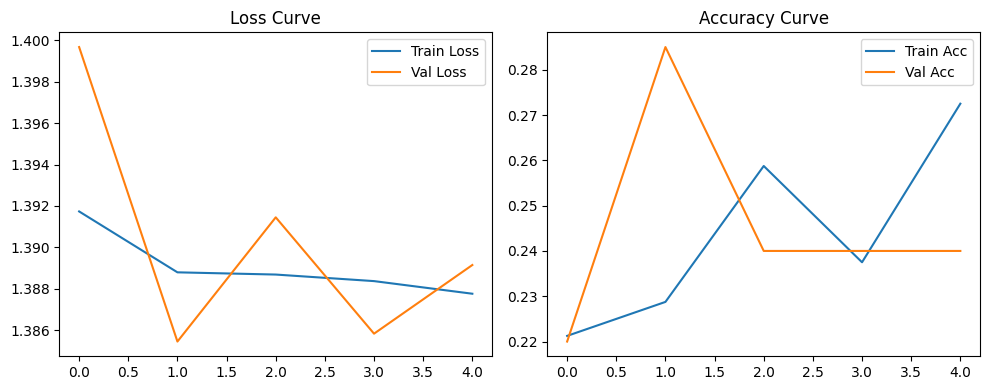

In [ ]:
# === 11. Plot Loss & Accuracy === #
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment_Label'])

X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check label mapping
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{'Happy': np.int64(0), 'Motivated': np.int64(1), 'Relaxed': np.int64(2), 'Sad': np.int64(3)}


Vectorize with TF-IDF

Tokenization and Padding
This turns text into padded integer sequences that can be input to the LSTM.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

vocab_size = 5000
max_length = 100
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)


Define the LSTM Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(df['clean_text'])

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       Happy       0.28      0.35      0.31        48
   Motivated       0.33      0.30      0.31        57
     Relaxed       0.21      0.27      0.24        44
         Sad       0.23      0.14      0.17        51

    accuracy                           0.27       200
   macro avg       0.26      0.27      0.26       200
weighted avg       0.27      0.27      0.26       200



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 64

from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(256, return_sequences=True),
    Dropout(0.5),
    LSTM(256),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

 Train the Model

In [ ]:
history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_test_pad, y_test_cat),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.2412 - loss: 1.3902 - val_accuracy: 0.2200 - val_loss: 1.3873
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2592 - loss: 1.3875 - val_accuracy: 0.2850 - val_loss: 1.3841
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2623 - loss: 1.3860 - val_accuracy: 0.2850 - val_loss: 1.3848
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2348 - loss: 1.3881 - val_accuracy: 0.2850 - val_loss: 1.3848
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2190 - loss: 1.3870 - val_accuracy: 0.2400 - val_loss: 1.3872
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2407 - loss: 1.3910 - val_accuracy: 0.2850 - val_loss: 1.3849
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2475 - loss: 1.3869 - val_accuracy: 0.2400 - val_loss: 1.3863
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2357 - loss: 1.3874 - val_accuracy: 0.2400 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
              precision    recall  f1-score   support

       Happy       0.24      1.00      0.39        48
   Motivated       0.00      0.00      0.00        57
     Relaxed       0.00      0.00      0.00        44
         Sad       0.00      0.00      0.00        51

    accuracy                           0.24       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.06      0.24      0.09       200

[[48  0  0  0]
 [57  0  0  0]
 [44  0  0  0]
 [51  0  0  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


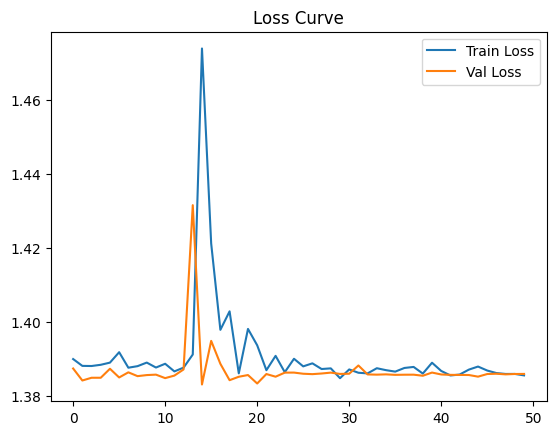

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predict classes
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
print(confusion_matrix(y_true, y_pred))

# Plot Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


<Axes: xlabel='Sentiment_Label'>

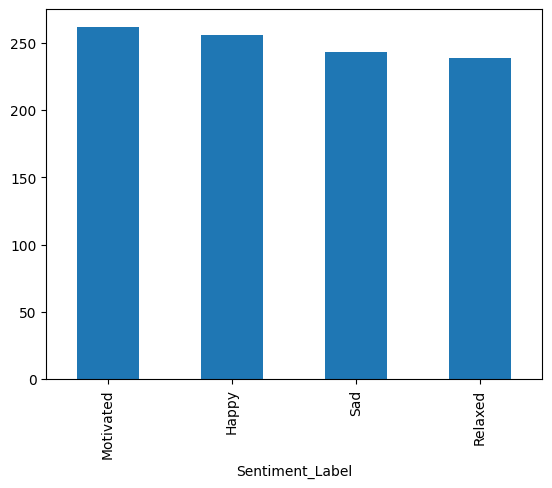

In [ ]:
df['Sentiment_Label'].value_counts().plot(kind='bar')


Classification Report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get predicted classes
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

       Happy       0.24      1.00      0.39        48
   Motivated       0.00      0.00      0.00        57
     Relaxed       0.00      0.00      0.00        44
         Sad       0.00      0.00      0.00        51

    accuracy                           0.24       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.06      0.24      0.09       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Confusion Matrix

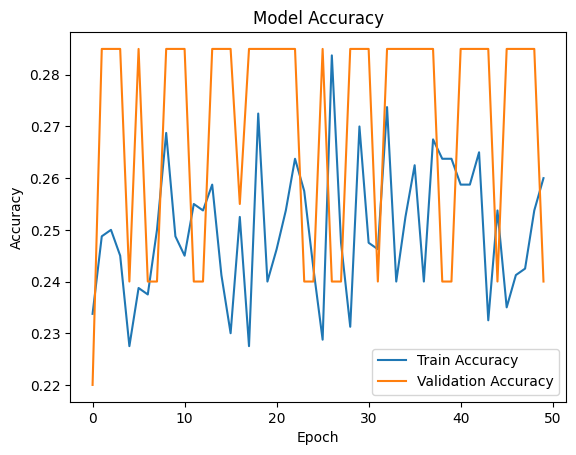

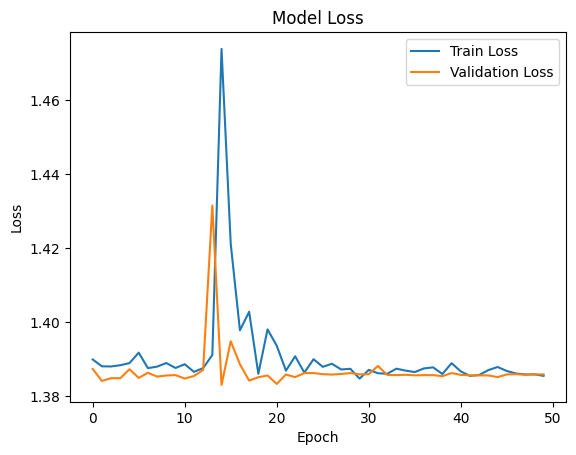

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get predicted classes
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1) # This is where y_true is defined

# Print classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
              precision    recall  f1-score   support

       Happy       0.24      1.00      0.39        48
   Motivated       0.00      0.00      0.00        57
     Relaxed       0.00      0.00      0.00        44
         Sad       0.00      0.00      0.00        51

    accuracy                           0.24       200
   macro avg       0.06      0.25      0.10       200
weighted avg       0.06      0.24      0.09       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training vs Validation Curves